# **Preprocess Data and Create Labels and Features**

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [88]:
DATA_PATH = os.path.join('My_Datasets')

actions = np.array(["maaf", "tolong", "nama", "saya", "siapa", "rumah", "start", "standby", "delete", "translate", "dimana"])

no_sequences = 30

sequence_length = 30

In [89]:

label_map = {label:num for num, label in enumerate(actions)}
label_map

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}-norm.npy".format(frame_num)))
            
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape

(330, 30, 108)

In [90]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(231, 30, 108)
(99, 30, 108)
(231, 11)
(99, 11)


# **Build and Train LSTM Neural Network**

In [91]:
checkpoint = ModelCheckpoint('test.h5', monitor='categorical_accuracy', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False,save_freq='epoch')

In [92]:
# model = Sequential()

# model.add(TimeDistributed(Dense(units=64, activation='tanh'), input_shape=(30, 108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(actions.shape[0], activation='softmax'))

# model.summary()

model = Sequential()

model.add(TimeDistributed(Dense(units=128, activation='tanh'), input_shape=(30, 108)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDi  (None, 30, 128)           13952     
 stributed)                                                      
                                                                 
 lstm_10 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_15 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                      

In [93]:
# model = Sequential()

# model.add(TimeDistributed(Dense(units=256, activation='tanh'), input_shape=(30, 108)))
# model.add(LSTM(128, return_sequences=False, activation='tanh', input_shape=(30,108)))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [94]:
# COMPLEX MODEL -> EXPERIMENTAL
# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.4))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [95]:
# COMPLEX MODEL 2

# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

Epoch 1/25


7/8 [=========================>....] - ETA: 0s - loss: 2.2818 - categorical_accuracy: 0.1741
Epoch 1: categorical_accuracy improved from -inf to 0.18182, saving model to test.h5
8/8 [==============================] - 4s 125ms/step - loss: 2.2750 - categorical_accuracy: 0.1818 - val_loss: 1.9019 - val_categorical_accuracy: 0.5051
Epoch 2/25
5/8 [=================>............] - ETA: 0s - loss: 1.8912 - categorical_accuracy: 0.4437

c:\Users\krisn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 1.8840 - categorical_accuracy: 0.4545
Epoch 2: categorical_accuracy improved from 0.18182 to 0.45455, saving model to test.h5
8/8 [==============================] - 0s 41ms/step - loss: 1.8840 - categorical_accuracy: 0.4545 - val_loss: 1.5907 - val_categorical_accuracy: 0.5455
Epoch 3/25
7/8 [=========================>....] - ETA: 0s - loss: 1.6296 - categorical_accuracy: 0.5089
Epoch 3: categorical_accuracy improved from 0.45455 to 0.51515, saving model to test.h5
8/8 [==============================] - 0s 37ms/step - loss: 1.6210 - categorical_accuracy: 0.5152 - val_loss: 1.3488 - val_categorical_accuracy: 0.5556
Epoch 4/25
6/8 [=====================>........] - ETA: 0s - loss: 1.4455 - categorical_accuracy: 0.5573
Epoch 4: categorical_accuracy improved from 0.51515 to 0.58442, saving model to test.h5
8/8 [==============================] - 0s 37ms/step - loss: 1.4168 - categorical_accuracy: 0.5844 - val_loss: 1.1307 - val_categori

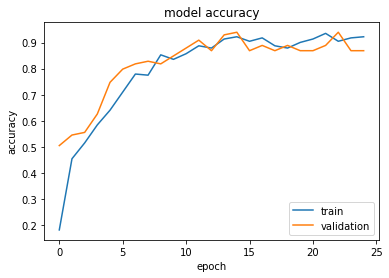

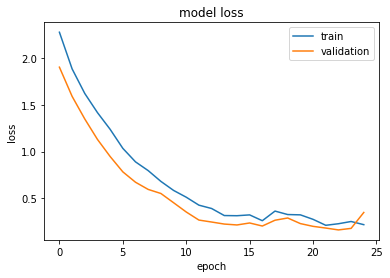

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDi  (None, 30, 128)           13952     
 stributed)                                                      
                                                                 
 lstm_10 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_15 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                      

In [96]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
train_model = model.fit(X_train, y_train, epochs=25, callbacks=[checkpoint], validation_data=(X_test, y_test))

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
    
model.summary()

In [97]:
# plot_model(model, to_file="model1.png", show_shapes=True)

# **Save Weights**

In [98]:
number_of_classes = len(actions)
current_date = '25032024' # changes manually
version = 2

model_filename ="model/model_" +  str(number_of_classes) + '_' + 'lstm' + '_' + current_date + '_' + str(version) + ".h5"

print(model_filename)

model.save(model_filename)
model.load_weights(model_filename)

model/model_11_lstm_25032024_2.h5


In [99]:
model.load_weights(model_filename)

# **Evaluation using Confusion Matrix and Accuracy**

In [100]:
yhat = model.predict(X_test)

4/4 [==============================] - 1s 8ms/step


In [101]:
print(actions[np.argmax(yhat[2])])
print(actions[np.argmax(y_test[2])])

tolong
siapa


In [102]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [103]:
from sklearn.metrics import classification_report

# Assuming ytrue and yhat are the true and predicted labels, respectively
report = classification_report(ytrue, yhat, target_names=actions)
print(report)

              precision    recall  f1-score   support

        maaf       1.00      0.91      0.95        11
      tolong       0.60      1.00      0.75         9
        nama       1.00      1.00      1.00         9
        saya       0.67      0.62      0.64        13
       siapa       0.50      0.30      0.37        10
       rumah       1.00      1.00      1.00         9
       start       1.00      1.00      1.00         6
     standby       1.00      1.00      1.00         8
      delete       1.00      1.00      1.00         5
   translate       1.00      1.00      1.00        10
      dimana       1.00      1.00      1.00         9

    accuracy                           0.87        99
   macro avg       0.89      0.89      0.88        99
weighted avg       0.87      0.87      0.86        99



In [104]:
# mcm = multilabel_confusion_matrix(ytrue, yhat)
# print(mcm)

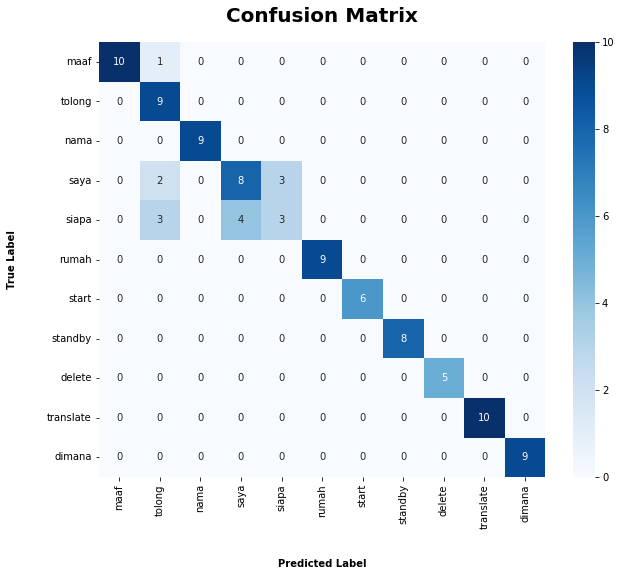

In [105]:
ytrue = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(10, 8))
heatMap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)

heatMap.set_xlabel('Predicted Label', labelpad=30, weight='bold')
heatMap.set_ylabel('True Label', labelpad=30, weight='bold')

heatMap.set_title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.show()

In [106]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming ytrue and yhat are the true and predicted labels, respectively
metrics = precision_recall_fscore_support(ytrue, yhat)

precision_per_class = metrics[0]
recall_per_class = metrics[1]
f1_score_per_class = metrics[2]

# Print metrics for each class
for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

# For accuracy per class, you would need to calculate it manually:
accuracy_per_class = [(conf_matrix[i, i] / np.sum(conf_matrix[:, i])) for i in range(len(actions))]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[i]}\n")

Class: maaf
Precision: 1.0
Recall: 0.9090909090909091
F1 Score: 0.9523809523809523

Class: tolong
Precision: 0.6
Recall: 1.0
F1 Score: 0.7499999999999999

Class: nama
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: saya
Precision: 0.6666666666666666
Recall: 0.6153846153846154
F1 Score: 0.64

Class: siapa
Precision: 0.5
Recall: 0.3
F1 Score: 0.37499999999999994

Class: rumah
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: start
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: standby
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: delete
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: translate
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: dimana
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: maaf
Accuracy: 1.0

Class: tolong
Accuracy: 0.6

Class: nama
Accuracy: 1.0

Class: saya
Accuracy: 0.6666666666666666

Class: siapa
Accuracy: 0.5

Class: rumah
Accuracy: 1.0

Class: start
Accuracy: 1.0

Class: standby
Accuracy: 1.0

Class: delete
Accuracy: 1.0

Class: translate
Accuracy: 1.